In [16]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:

import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings

In [18]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [19]:
data_dir = Path('../input/')
feature_dir = Path('../feature/')
sub_dir = Path('../submission/')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = sub_dir / 'sample_submission.csv'

target_col = 'class'
seed = 42

In [20]:
algo_name = 'lgb'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [21]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 20)


,u,g,r,i,z,redshift,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
id,,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,0.0000
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,0.0000
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,0.0000
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,0.2231
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,0.0741


In [22]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000]
tst = df.iloc[320000:]
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 19) (80000, 19)


In [23]:

X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)
print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

(256000, 19) (64000, 19) (256000,) (64000,)


In [25]:
clf = lgb.LGBMClassifier(objective='multiclass',
                         n_estimators=1000,
                         num_leaves=64,
                         learning_rate=0.1,
                         min_child_samples=10,
                         subsample=.5,
                         subsample_freq=1,
                         colsample_bytree=.8,
                         random_state=seed,
                         n_jobs=-1)
clf.fit(X_trn, y_trn,
        eval_set=[(X_val, y_val)],
        eval_metric='multiclass',
        early_stopping_rounds=10)
p_val = clf.predict(X_val)
p_tst = clf.predict(tst)

[1]	valid_0's multi_logloss: 0.871311
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.763774
[3]	valid_0's multi_logloss: 0.684413
[4]	valid_0's multi_logloss: 0.612971
[5]	valid_0's multi_logloss: 0.563635
[6]	valid_0's multi_logloss: 0.512739
[7]	valid_0's multi_logloss: 0.476116
[8]	valid_0's multi_logloss: 0.441592
[9]	valid_0's multi_logloss: 0.41412
[10]	valid_0's multi_logloss: 0.385429
[11]	valid_0's multi_logloss: 0.363962
[12]	valid_0's multi_logloss: 0.345442
[13]	valid_0's multi_logloss: 0.330359
[14]	valid_0's multi_logloss: 0.312887
[15]	valid_0's multi_logloss: 0.298481
[16]	valid_0's multi_logloss: 0.287736
[17]	valid_0's multi_logloss: 0.276407
[18]	valid_0's multi_logloss: 0.265588
[19]	valid_0's multi_logloss: 0.256906
[20]	valid_0's multi_logloss: 0.248264
[21]	valid_0's multi_logloss: 0.240813
[22]	valid_0's multi_logloss: 0.235525
[23]	valid_0's multi_logloss: 0.228916
[24]	valid_0's multi_logloss: 0.223362
[25]	valid_0'

In [26]:
print(f'{accuracy_score(y_val, p_val) * 100:.4f}%')

93.0562%


<AxesSubplot:ylabel='feature'>

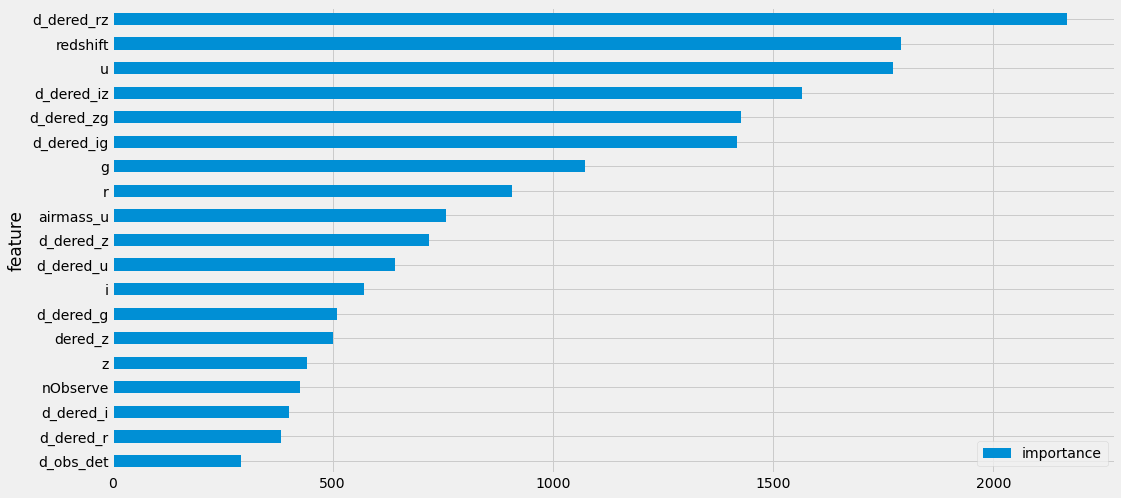

In [27]:

imp = pd.DataFrame({'feature': trn.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [28]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [29]:
sub[target_col] = p_tst
sub.head()

,class
id,
320000,2.0
320001,0.0
320002,2.0
320003,0.0
320004,2.0


In [30]:
sub[target_col].value_counts()

2.0    41111
0.0    29984
1.0     8905
Name: class, dtype: int64

In [31]:
sub.to_csv(sub_file)